In [1]:
import pyvisa
import csv
import numpy as np
import time
import matplotlib.pyplot as plt
import keyoscacquire as koa
import pandas as pd

In [2]:
rm = pyvisa.ResourceManager()
scope = koa.Oscilloscope(address='USB0::0x0957::0x1796::MY56272306::INSTR', timeout=300000)

Connected to:
  AGILENT TECHNOLOGIES
  DSO-X 2024A (serial MY56272306)


In [3]:
scope.acq_type = 'HRES'
scope.p_mode = 'RAW'
scope.wav_format = 'WORD'
#scope.write(':timebase:scale 5')
scope.write(':CHAN1:PROB 1')
scope.write(':CHAN2:PROB 1')
#scope.write(':CHAN3:PROB 1')

In [4]:
nrep = 1
for i in range(0, nrep):
    if i == 0:
        time_, y, channel_numbers = scope.get_trace(channels=[1,2])
        #time_, y, channel_numbers = scope.get_trace(channels=[1,2,3])
    else:
        tmp_time, tmp_y, tmp_channel_numbers = scope.get_trace(channels=[1,2])
        time_ = np.concatenate([time_, tmp_time])
        y = np.concatenate([y, tmp_y])
        

Acquisition type: HRES
From channels:    [1, 2]
Acquiring (format 'WORD').. done
Points captured per channel:  250,000


In [6]:
# Save raw data to file

columns = ['time [s]', 'power_signal [V]', 'diode_signal [V]']
#columns = ['time [s]', 'temp_signal [V]', 'power_signal [V]', 'diode_signal [V]']
rows = np.concatenate([time_, y], axis=1)

with open(r'C:\Users\lmoza\Documents\wgms\free_space_coupling\6-15\psd_100s_nd_off.csv', 'w') as f:
    write = csv.writer(f)
    write.writerow(columns)
    write.writerows(rows)

In [19]:
# Calculate average CH 2 values for equivalent CH 1 values
y_avg_p_and_t = pd.DataFrame(y[:,[0,1]]).groupby(0).mean().reset_index().values

# Calculate std
u_err_p_and_t = (pd.DataFrame(y[:,[0,1]]).groupby(0).std().values)[:,0]
l_err_p_and_t = (pd.DataFrame(y[:,[0,1]]).groupby(0).std().values)[:,0]

In [18]:
y[:,[0,1]]

array([[3.02229859, 0.6166959 ],
       [3.02229859, 0.6166959 ],
       [3.02229859, 0.6166959 ],
       ...,
       [3.0348614 , 0.6166959 ],
       [3.0348614 , 0.6166959 ],
       [3.0348614 , 0.6166959 ]])

Text(0, 0.5, 'Power Signal [V]')

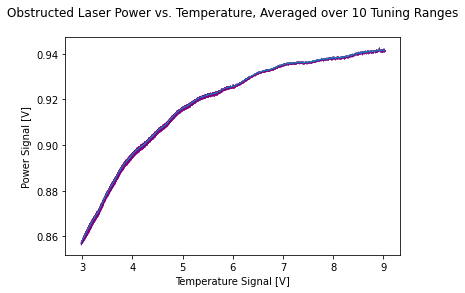

In [25]:
# Plot average power signal with error
plt.errorbar(y_avg_p_and_t[:,0], y_avg_p_and_t[:,1],yerr = [l_err_p_and_t, u_err_p_and_t], ecolor='purple', linewidth=.8, label='data')
plt.title('Obstructed Laser Power vs. Temperature, Averaged over 10 Tuning Ranges\n')
plt.xlabel('Temperature Signal [V]')
plt.ylabel('Power Signal [V]')

In [21]:
# Calculate average CH 3 values for equivalent CH 1 values
y_avg_d_and_t = pd.DataFrame(y[:,[0,2]]).groupby(0).mean().reset_index().values

# Calculate std
u_err_d_and_t = (pd.DataFrame(y[:,[0,2]]).groupby(0).std().values)[:,0]
l_err_d_and_t = (pd.DataFrame(y[:,[0,2]]).groupby(0).std().values)[:,0]

Text(0, 0.5, 'Power Signal [V]')

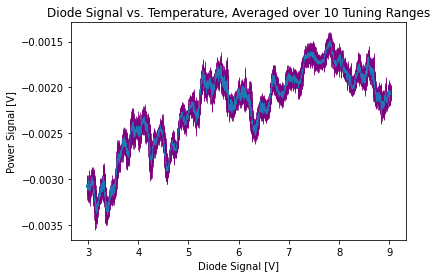

In [22]:
# Plot average diode signal with error
plt.errorbar(y_avg_d_and_t[:,0], y_avg_d_and_t[:,1],yerr = [l_err_d_and_t, u_err_d_and_t], ecolor='purple', linewidth=.8, label='data')
plt.title('Diode Signal vs. Temperature, Averaged over 10 Tuning Ranges')
plt.xlabel('Diode Signal [V]')
plt.ylabel('Power Signal [V]')

In [23]:
# Extracting necessary preamble data for conversion

# Scope, for some reason, has to re-run itself when the preamble query is made
# To prevent waiting a long time, change the horizontal scale to a very short period 
# (this will not change the info that is relevant to us)
scope.write(':timebase:scale .0001')

scope.write(':WAV:SOUR CHAN1')
preamble_str1 = scope.query(':WAV:PRE?')
scope.write(':WAV:SOUR CHAN2')
preamble_str2= scope.query(':WAV:PRE?')
scope.write(':WAV:SOUR CHAN3')
preamble_str3= scope.query(':WAV:PRE?')


preamble_ch1 = preamble_str1.split(',')
preamble_ch2 = preamble_str2.split(',')
preamble_ch3 = preamble_str3.split(',')


y_inc_ch1 = preamble_ch1[7]
y_or_ch1 = preamble_ch1[8]
y_ref_ch1 = preamble_ch1[9]

y_inc_ch2 = preamble_ch2[7]
y_or_ch2 = preamble_ch2[8]
y_ref_ch2 = preamble_ch2[9]

y_inc_ch3 = preamble_ch3[7]
y_or_ch3 = preamble_ch3[8]
y_ref_ch3 = preamble_ch3[9]


print('CH1 --> y-increment:', y_inc_ch1, 'y-origin:', y_or_ch1, 'y_reference:', y_ref_ch1)
print('CH2 --> y-increment:', y_inc_ch2, 'y-origin:', y_or_ch2, 'y_reference:', y_ref_ch2)
print('CH3 --> y-increment:', y_inc_ch3, 'y-origin:', y_or_ch3, 'y_reference:', y_ref_ch3)

CH1 --> y-increment: +1.57035200E-004 y-origin: +6.47500000E+000 y_reference: +0
CH2 --> y-increment: +3.14070300E-006 y-origin: +9.06500000E-001 y_reference: +0
CH3 --> y-increment: +6.28140700E-007 y-origin: -9.00000000E-004 y_reference: +0


In [57]:
# Export average data to csv

buff = y_avg_d_and_t[:,1]
avg_diode = np.array(buff)[:,None]

columns = ['avg_temp_signal [V]', 'avg_power_signal [V]', 'avg_diode_signal [V]']
rows = np.concatenate([y_avg_p_and_t, avg_diode], axis=1)

with open(r'C:\Users\lmoza\Documents\wgms\scope_data\6-14-three-ch-measurement-AVG.csv', 'w') as f:
    write = csv.writer(f)
    write.writerow(columns)
    write.writerows(rows)